In [232]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm
from scipy.interpolate import CubicSpline
from scipy.spatial import Delaunay
from itertools import chain, product
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
import yaml

In [233]:
""" FSG rulebook/handbook specifications """
"""
    D8.1 Trackdrive Tracklayout
        • Constant Turns: up to 50 m diameter
        • Hairpin Turns: Minimum of 9 m outside diameter (of the turn)
        • Miscellaneous: Chicanes, multiple turns, decreasing radius turns, etc.
        • The minimum track width is 3 m
        • Distance between cones is maximally 5 m
    D8.1.2 The length of one lap is approximately 200 m to 500 m.
"""
parameters = yaml.safe_load(open("parameters.yaml"))

1.1118008358602203 3.322859420619054
1.1490339556669984 3.5404401471913793


(-3.080201234059068, 44.85362835113758, -0.6071128373164829, 33.40058016396625)

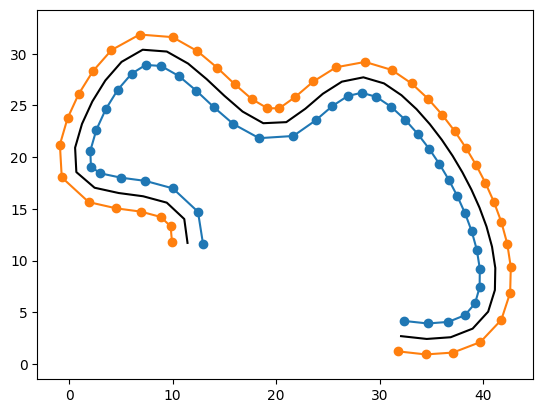

In [234]:
def generate_trajectory(c = 0.1, p: dict = {}) -> (np.ndarray, np.ndarray, np.ndarray):
    """
        Generate a trajectory which is a path through a Delaunay triangulation
        Respects global parameter `max_cone_dist`
        Also respects maximum curvature of the path
    """
    max_cone_dist = p["max_cone_dist"]
    min_cone_dist = p["min_cone_dist"]
    max_dist = p["max_dist"]
    fov_deg = p["fov_deg"]
    fov_rad = fov_deg * np.pi / 180

    # Generate data
    N = 20
    x = np.random.uniform(0, 1, size=(N,2))

    # Filter points that are close to each other
    k = True
    I = np.arange(N)
    while k:
        k = False
        for i, j in enumerate(I):
            y = np.linalg.norm(x[j] - x[I], axis=1)
            y[i] = np.inf
            m = y < c

            if np.any(m):
                k = True
                I = I[~m]
                break
    x = x[I]

    # Create Delaunay triangulation
    simplices = Delaunay(x).simplices

    I = [ 0 ]
    S = set(I)
    T = { i: [] for i in range(N) }
    for i, j, k in simplices:
        T[i] += [ (i, j, k) ]
        T[j] += [ (i, j, k) ]
        T[k] += [ (i, j, k) ]

    # Find a path through the triangulation
    for _ in range(2 * int(np.sqrt(N))):
        i = I[-1]
        K = list(filter(lambda k: k not in S, chain(*T[i])))
        if not K:
            break
        K = sorted(K, key=lambda k: -np.linalg.norm(x[k] - x[i]))
        k = K[-1]
        I += [ k ]
        S |= { k }
    x = x[I]

    # Smoothen the path
    X = CubicSpline(np.arange(len(x)), x, axis=0)

    t = np.linspace(0, len(x) - 1, 200)
    x = X(t)

    while True:
        n = np.roll(x, 1, axis=0) - x
        n[0] = n[1]
        s = np.cumsum(np.linalg.norm(n, axis=1))
        dn = np.roll(n, 1, axis=0) - n
        dn[0] = dn[1]
        k = np.abs(dn[:, 0] * n[:, 1] - dn[:, 1] * n[:, 0]) / (n[:, 0]**2 + n[:, 1]**2)**(3/2)
        k_max = np.max(k)
        s_max = s[-1]

        if (s_max < 90) or (1.5 / min_cone_dist < k_max):
            x *= 1.1
        else:
            n = np.roll(x, 1, axis=0) - x
            n[0] = n[1]
            s = np.cumsum(np.linalg.norm(n, axis=1))
            dn = np.roll(n, 1, axis=0) - n
            dn[0] = dn[1]
            k = np.abs(dn[:, 0] * n[:, 1] - dn[:, 1] * n[:, 0]) / (n[:, 0]**2 + n[:, 1]**2)**(3/2)
            break

    return x, s, k

def generate_cones(p: dict = {}) -> (np.ndarray, np.ndarray, np.ndarray):
    """
        Generate a set of cones which are placed along a trajectory
        Respects global parameters `max_cone_dist` and `min_cone_dist`
    """
    max_cone_dist = p["max_cone_dist"]
    min_cone_dist = p["min_cone_dist"]
    max_dist = p["max_dist"]
    fov_deg = p["fov_deg"]
    fov_rad = fov_deg * np.pi / 180

    # Find a trajectory which isn't too long, with not too step turns
    while True:
        x, s, k = generate_trajectory(p=p)
        if s[-1] < 300:
            break
    n = np.roll(x, 1, axis=0) - x; n[0] = n[1]; n /= np.linalg.norm(n, axis=1, keepdims=True)
    yaw = np.arctan2(n[:,1], n[:,0])

    # Find an interpolation which respects the maximum distance between cones
    S = np.cumsum(max_cone_dist * 1 / (min_cone_dist * k + 2))
    S = S[S < s[-1]]

    # Create dataset
    x = np.vstack((
        np.interp(S, s, x[:,0]),
        np.interp(S, s, x[:,1]),
    )).T
    n = np.vstack((
        np.interp(S, s, n[:,0]),
        np.interp(S, s, n[:,1]),
    )).T
    y = np.interp(S, s, yaw)
    v = np.vstack((n[:,1], -n[:,0])).T
    l = x + min_cone_dist * v / 2
    r = x - min_cone_dist * v / 2

    return x, l, r, y

x, l, r, y = generate_cones(p = parameters)
dl = np.linalg.norm(np.diff(l, axis=0), axis=1)
dr = np.linalg.norm(np.diff(r, axis=0), axis=1)
print(np.min(dl), np.max(dl))
print(np.min(dr), np.max(dr))
plt.plot(x[:,0], x[:,1], 'k-')
plt.plot(l[:,0], l[:,1], 'o-')
plt.plot(r[:,0], r[:,1], 'o-')
plt.axis('equal')

(-3.587227298089875, 55.501175695784525, -1.748450917770608, 57.36867985350287)

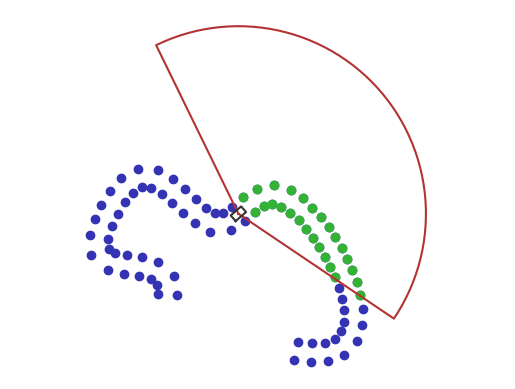

In [235]:
i = len(x) // 2
cones = homogenize(np.vstack((l, r)))
pose = np.array([ x[i, 0], x[i, 1], y[i] ])
visible_cones = get_visible_cones(cones, pose, p=parameters)

plot_cones(cones)
plot_cones(visible_cones, color=(0.2,0.7,0.2))
plot_fov(pose, p=parameters)
plot_car(pose, p=parameters)
plt.axis('equal')
plt.axis('off')

In [236]:
_m, _n = 1, 1
def points_in_track(y: np.ndarray((_m,3)), x: np.ndarray((_n,3)), p: dict = {}):
    threshold = p["min_cone_dist"]
    D = np.linalg.norm(y[:,:2].reshape((-1, 1, 2)) - x[:,:2].reshape((1, -1, 2)), axis=2)
    d = np.min(D, axis=1)
    assignment = np.argmin(D, axis=1)
    return d < threshold

assert np.all(points_in_track(homogenize(x), homogenize(x), p=parameters))

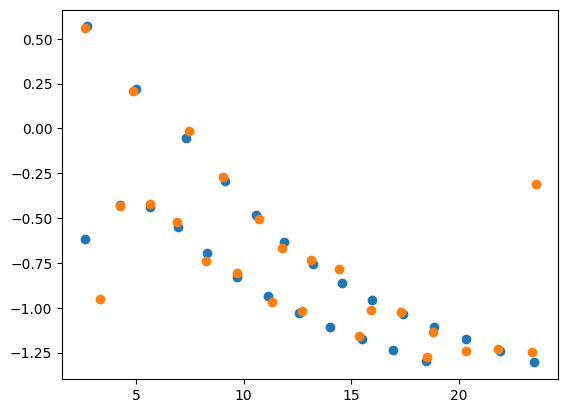

In [237]:
_n = 1
def get_measurement(cones: np.ndarray((_n, 3)), pose: np.ndarray((3,)), p: dict = {}) -> np.ndarray((_n, 3)):
    visible_cones = get_visible_cones(cones, pose, p=p)
    return to_m_frame(visible_cones, pose)

def get_measurement_track(x: np.ndarray((_n, 3)), pose: np.ndarray((3,)), p: dict = {}) -> np.ndarray((_n, 3)):
    max_dist = p["max_dist"]
    max_fov_rad = p["fov_deg"] * np.pi / 180
    W = p['W']
    H = p['H']
    w = np.linspace(0, max_dist, 2*W)
    h = np.linspace(-max_fov_rad/2, max_fov_rad/2, 2*H)
    points_m = np.array(list(product(w, h))).reshape((-1, 2))
    points_m = homogenize(points_m)
    points_g = to_g_frame(points_m, pose)
    in_track = points_in_track(points_g, x, p=parameters)
    return points_m[in_track]

def disturb_measurement(measurement: np.ndarray((_n, 3)), p: dict = {}) -> np.ndarray((_n, 3)):
    max_dist = p["max_dist"]
    fov_rad = p["fov_deg"] * np.pi / 180
    false_negative_rate = p["false_negative_rate"]
    false_positive_rate = p["false_positive_rate"]
    measurement_noise_fov_deg = p["measurement_noise_fov_deg"]
    measurement_noise_dist = p["measurement_noise_dist"]

    n_fov_rad = measurement_noise_fov_deg * np.pi / 180
    n_dist = measurement_noise_dist

    n = measurement.shape[0]
    measurement += np.random.normal(0, 1, size=(n, 3)) @ np.diag([n_dist, n_fov_rad, 0])

    noisy_measurement = []
    for (angle, distance, likelihood) in measurement:
        if np.random.uniform() < false_negative_rate:
            continue
        if np.random.uniform() < false_positive_rate:
            noisy_measurement += [ (np.random.uniform(0, max_dist), np.random.uniform(-fov_rad/2, fov_rad/2), np.random.uniform(0, 0.4)) ]
        else:
            noisy_measurement += [ (angle, distance, np.random.uniform(0.6, 0.95)) ]
    
    return np.array(noisy_measurement)

measurement = get_measurement(cones, pose, p=parameters)
plt.plot(measurement[:,0], measurement[:,1], 'o')

measurement = disturb_measurement(measurement, p=parameters)
plt.plot(measurement[:,0], measurement[:,1], 'o')

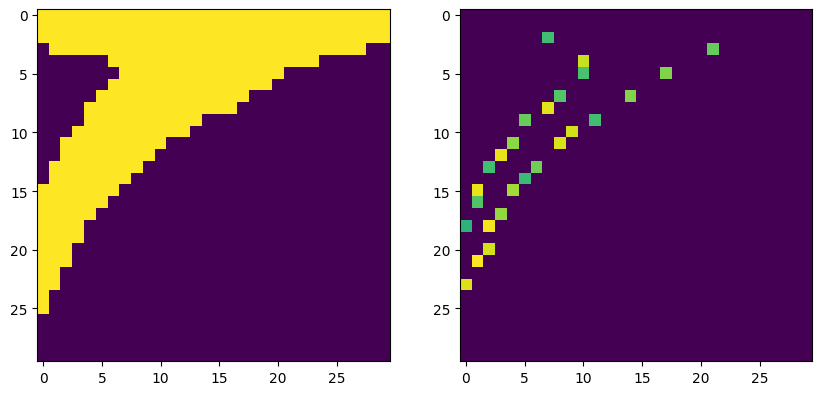

In [238]:
_W, _H = 1, 1
def discretize_m_frame(measurement: np.ndarray((_n, 3)), p: dict = {}) -> np.ndarray((_W,_H)):
    W = p['W']
    H = p['H']
    max_dist = p["max_dist"]
    max_fov_rad = p["fov_deg"] * np.pi / 180

    w = np.linspace(0, max_dist, W)
    h = np.linspace(-max_fov_rad/2, max_fov_rad/2, H)

    def discretize(angle, distance):
        i = np.argmin(np.abs(w - distance))
        j = np.argmin(np.abs(h - angle))
        return i, j
    
    grid = np.zeros((W, H))

    for distance, angle, likelihood in measurement:
        i, j = discretize(angle, distance)
        grid[i, j] = max(grid[i, j], likelihood)
    
    return grid

def undiscretize_m_frame(measurement: np.ndarray((_n,3)), p: dict = {}) -> np.ndarray((_n, 3)):
    W = p['W']
    H = p['H']
    max_dist = p["max_dist"]
    max_fov_rad = p["fov_deg"] * np.pi / 180

    w = np.linspace(0, max_dist, W)
    h = np.linspace(-max_fov_rad/2, max_fov_rad/2, H)

    def undiscretize(i, j):
        distance = w[int(i)]
        angle = h[int(j)]
        return angle, distance
    
    measurements = []
    for i, j, p in measurement:
        angle, distance = undiscretize(i, j)
        likelihood = np.clip(p, 0, 1)
        measurements += [ (distance, angle, likelihood) ]
    
    return np.array(measurements)

measurement = get_measurement(cones, pose, p=parameters)
track = get_measurement_track(x, pose, p=parameters)
facit = discretize_m_frame(track, p=parameters)

measurement = disturb_measurement(measurement, p=parameters)
grid = discretize_m_frame(measurement, p=parameters)

ax1, ax2 = plt.subplots(1, 2, figsize=(10, 5))[1]
ax1.imshow(facit)
ax2.imshow(grid)

In [239]:
from concurrent.futures import ThreadPoolExecutor

N, M = parameters['N'], parameters['M']
K = N*M
W, H = parameters['W'], parameters['H']

measurements = np.zeros((N*M, W, H))
facits = np.zeros((N*M, W, H))

def process_n(n):
    x, l, r, y = generate_cones(p = parameters)

    i = len(x) // 2
    cones = homogenize(np.vstack((l, r)))

    for m in range(M):
        x_dis = np.random.uniform(-1, 1)
        y_dis = np.random.uniform(-1, 1)
        p_dis = np.random.uniform(-1, 1) * np.pi / 3
        pose = np.array([ x[i, 0] + x_dis, x[i, 1] + y_dis, y[i] + p_dis ])

        measurement = get_measurement(cones, pose, p=parameters)
        track = get_measurement_track(x, pose, p=parameters)
        facit = discretize_m_frame(track, p=parameters)

        measurement = disturb_measurement(measurement, p=parameters)
        measurement = discretize_m_frame(measurement, p=parameters)

        e = n * M + m
        measurements[e] = measurement
        facits[e] = facit

try:
    data = np.load('data.npz')
    measurements = data['measurements']
    facits = data['facits']
except FileNotFoundError:
    with ThreadPoolExecutor() as executor:
        list(tqdm(executor.map(process_n, range(N)), total=N))
    np.savez_compressed('data.npz', measurements=measurements, facits=facits)

In [240]:
""" Create a convolutional neural network """
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, 3, padding=1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.fc(x)

""" Train the network """
network = Network()

try:
    network.load_state_dict(torch.load('network.pth'))

except FileNotFoundError:
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    for epoch, b in enumerate(np.random.permutation(K)):
        x = torch.tensor(measurements[b]).float().reshape((1, 1, W, H))
        y = torch.tensor(facits[b]).float().reshape((1, 1, W, H))

        optimizer.zero_grad()
        y_hat = network(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        if epoch % int(np.sqrt(N*M)) == 0:
            print(epoch, loss.item())

    torch.save(network.state_dict(), 'network.pth')

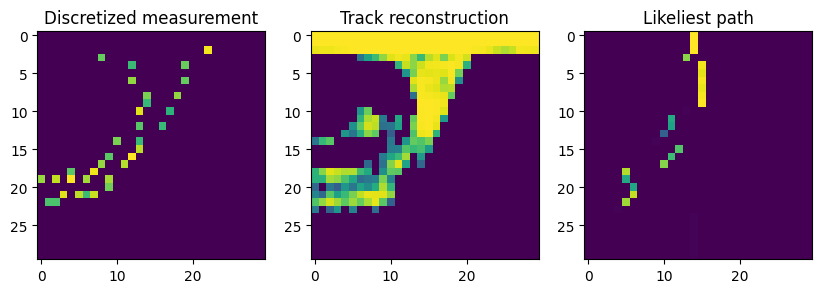

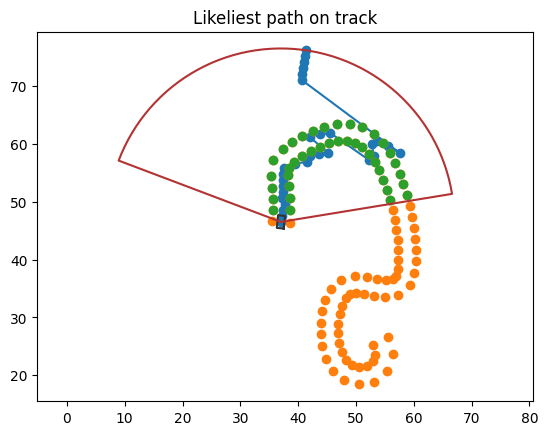

In [241]:
""" Validate """
x, l, r, y = generate_cones(p = parameters)

i = len(x) - 1
cones = homogenize(np.vstack((l, r)))
pose = np.array([ x[i, 0], x[i, 1], y[i] ])

measurement = get_measurement(cones, pose, p=parameters)
track = get_measurement_track(x, pose, p=parameters)
ground_truth = discretize_m_frame(track, p=parameters)

measurement = disturb_measurement(measurement, p=parameters)
measurement = discretize_m_frame(measurement, p=parameters)

m = torch.tensor(measurement).float().reshape((1, 1, W, H))
reconstruction = network(m).detach().numpy().reshape((W, H))
reconstruction[reconstruction < 0.3] = 0.01

W, H = parameters['W'], parameters['H']
G = 0*reconstruction.copy()
z = [ ]
for w in range(W):
    h = int(np.sum(reconstruction[w, :] * np.arange(H))/np.sum(reconstruction[w, :]))
    z += [ (w, h, reconstruction[w, h]) ]
    G[w, h] = reconstruction[w, h]
z = np.array(z)
z = undiscretize_m_frame(z, p=parameters)
z = to_g_frame(z, pose)

ax1, ax2, ax3 = plt.subplots(1, 3, figsize=(10, 5))[1]
ax1.imshow(measurement)
ax1.set_title('Discretized measurement')
ax2.imshow(reconstruction)
ax2.set_title('Track reconstruction')
ax3.imshow(G)
ax3.set_title('Likeliest path')
plt.show()

plt.title('Likeliest path on track')
i = len(x) - 1
cones = homogenize(np.vstack((l, r)))
pose = np.array([ x[i, 0], x[i, 1], y[i] ])
visible_cones = get_visible_cones(cones, pose, p=parameters)
plt.plot(z[:,0], z[:,1], 'o-')
plt.plot(cones[:,0], cones[:,1], 'o')
plt.plot(visible_cones[:,0], visible_cones[:,1], 'o')
plot_car(pose, p=parameters)
plot_fov(pose, p=parameters)
plt.axis('equal')
plt.show()

In [242]:
def get_likeliest_path(reconstruction: np.ndarray((_W,_H)), pose: np.ndarray((3,)), p: dict = {}):
    W, H = p['W'], p['H']
    z = [ ]
    for w in range(W):
        h = int(np.sum(reconstruction[w, :] * np.arange(H))/np.sum(reconstruction[w, :]))
        z += [ (w, h, reconstruction[w, h]) ]
    z = np.array(z)
    z = undiscretize_m_frame(z, p=parameters)
    return to_g_frame(z, pose)

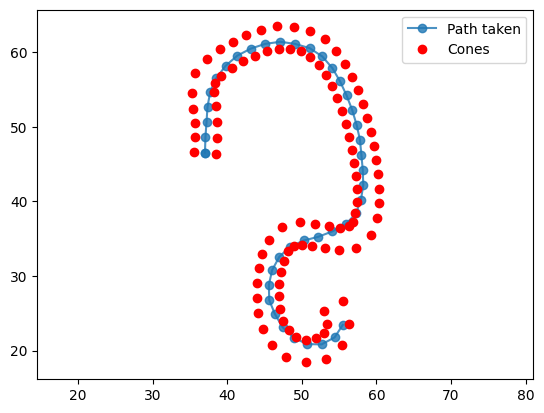

In [243]:
""" Check how a simple control-rule would navigate the track """
i = len(x) - 1
pose = np.array([ x[i, 0], x[i, 1], y[i] ])
poses = [ pose, pose ]

for k in range(40):
    # get discretized measurement in m frame
    measurement = get_measurement(cones, pose, p=parameters)
    measurement = disturb_measurement(measurement, p=parameters)
    measurement = discretize_m_frame(measurement, p=parameters)

    # get discretized reconstruction in m frame
    rec = torch.tensor(measurement).float().reshape((1, 1, W, H))
    reconstruction = network(rec).detach().numpy().reshape((W, H))

    # get likeliest path in g frame
    likeliest_path = get_likeliest_path(reconstruction, pose, p=parameters)
    for _ in range(7):
        likeliest_path[1:-1] = (likeliest_path[1:-1] + likeliest_path[:-2] + likeliest_path[2:]) / 3
    
    next_pose = np.array([
        likeliest_path[2, 0],
        likeliest_path[2, 1],
        np.arctan2(likeliest_path[2, 1] - likeliest_path[1, 1], likeliest_path[2, 0] - likeliest_path[1, 0]),
    ])

    pose = next_pose
    poses += [ pose ]

w = np.array(poses)
plt.plot(w[:,0], w[:,1], 'o-', label='Path taken', alpha=0.8)
plt.plot(cones[:,0], cones[:,1], 'or', label='Cones')
plt.legend()
plt.axis('equal')
plt.show()